# A Graph Neural Network (GNN)  from Scratch for semi-supervised learning
# Goals : 
1. An illustration of GNN for semi-supervised learning
2. A toy applicaion to community detection
3. A lecture on Structured Machine Learning

# Author: Romain Raveaux (romain.raveaux@univ-tours.fr)
## This notebook is a follow-up of "A Graph Neural Network (GNN)  from Scratch for semantic image segmentation" see the link : 
http://romain.raveaux.free.fr/   then teaching section

## Install requirements

*   [Network](https://networkx.github.io/)
*   [Pytorch](https://pytorch.org/)

# The lecture
The content of the is notebook is based on the following lectures : 
Supervised Machine Learning for structured input/output: Polytech, Tours

*   1\. Introduction to supervised Machine Learning: A probabilistic introduction [PDF](http://romain.raveaux.free.fr/document/courssupervisedmachinelearningRaveaux.pdf)

*   2\. Connecting local models : The case of chains [PDF slides](http://romain.raveaux.free.fr/document/Connecting%20local%20models%20the%20case%20of%20chains%20.pdf)

*   3\. Connecting local models : Beyond chains and trees.[PDF slides](http://romain.raveaux.free.fr/document/Structured%20Output%20Learning.pdf)

*   4\. Machine Learning and Graphs : Introduction and problems [PDF slides](http://romain.raveaux.free.fr/document/cours%20IA%20DI5%20graphs%20introV2.pdf)

*   5\. **Graph Neural Networks.** [PDF slides](http://romain.raveaux.free.fr/document/graph%20neural%20networks%20romain%20raveaux.pdf)

*   6\. Graph Kernels. [PDF slides](http://romain.raveaux.free.fr/document/graph%20kernel%20romain%20raveaux.pdf)

*   7\. Appendix : Introduction to deep learning. [PDF slides](http://romain.raveaux.free.fr/document/DeepLearningRRv2.pdf)


In [1]:
#load of import
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.animation as animation
%matplotlib inline  
from IPython.display import HTML


# Zachary’s Karate Club
Briefly, Zachary’s Karate Club is a small social network where a conflict arises between the administrator and instructor in a karate club. The task is to predict which side of the conflict each member of the karate club chooses. The graph representation of the network can be seen below. Each node represents a member of the karate club and a link between members indicate that they interact outside the club. The Administrator and Instructor marked with A and I, respectively.

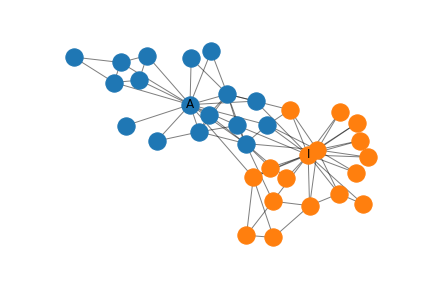

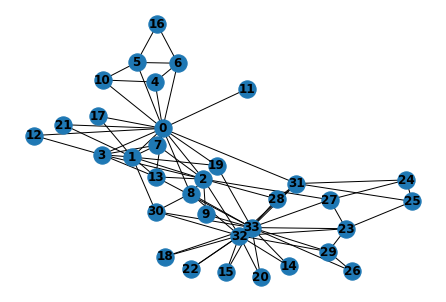

We have 34 nodes.
We have 78 edges.


In [2]:
from networkx import karate_club_graph, to_numpy_matrix
G = karate_club_graph()
#order = sorted(list(G.nodes()))
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

# Assign features to nodes or edges
Graph neural networks associate features with nodes and edges for training. For our classification example, we assign each node an input feature as a one-hot vector: node $v_i$‘s feature vector is $[0,…,1,…,0]$, where the $i^{th}$ position is one.

In DGL, you can add features for all nodes at once, using a feature tensor that batches node features along the first dimension. The code below adds the one-hot feature for all nodes:

In [3]:
import torch

eye=np.eye(34)

node_label = {}
for i in range(G.number_of_nodes()):
    node_label[i]=eye[i,:]
nx.set_node_attributes(G,node_label,'feature')


print(len(G.nodes))
print(len(G.edges))
print(G.number_of_nodes())
print(G.number_of_edges())


listnodes = list(G.nodes(data='feature'))
n=listnodes[0]
print(n)
print(n[1].shape)


34
78
34
78
(0, array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
(34,)


# Let 's us get the node features and the adjacency matrix

In [4]:
nodelist, nodesfeatures = map(list, zip(*G.nodes(data='feature')))
print(len(nodesfeatures))
nodesfeatures = np.array(nodesfeatures)
print(nodesfeatures.shape)
nodesfeatures = torch.from_numpy(nodesfeatures).float()
adjacencymatrix = np.array(nx.adjacency_matrix(G, nodelist=nodelist).todense())
print(adjacencymatrix.shape)
adjacencymatrix = torch.from_numpy(adjacencymatrix).float()

34
(34, 34)
(34, 34)


# Data preparation and initialization
We use one-hot vectors to initialize the node features. Since this is a semi-supervised setting, only the instructor (node 0) and the club president (node 33) are assigned labels. The implementation is available as follow.

In [5]:
#inputs = torch.eye(34)
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
print(labeled_nodes)
labels = torch.tensor([0, 1])  # their labels are different
print(labels)

tensor([ 0, 33])
tensor([0, 1])


## Define a Model : Graph Convolution layer

Firstly, we have to define a Graph Convolution layer.
$$f(H^{(l)},\hat{A})=\hat{A}.H^{(l)}.W^{(l)}$$
$$\hat{A}=A+I$$
A is the adjacency matrix and I the identity matrix.

In [6]:
import torch
import torch.nn as nn

class GraphConvolution(nn.Module):
  """
     Graph convolution layer
  """
  
  def __init__(self, in_features, out_features, bias=True, batchnorm=False):
    super(GraphConvolution, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.bias = bias
    self.fc = nn.Linear(1*self.in_features, self.out_features, bias=self.bias)
    
    self.batchnorm = batchnorm
    
      
  #H are node features for all graphs batch
  #W are adjacency matrix for all graphs batch
  #A is the set of operators
  # GraphConv = A.H.W
  def forward(self, H, A):
     
    
    res = torch.matmul(A, H)
    
    
    #FC is just a linear function input multiplied by the paramaters W
    output = self.fc(res)
    
    return output

# Let us define the network : 2 graph conv layers

In [7]:
# A Simple model with 2 graph conv layers 
# activation function are ReLus
class Net(nn.Module):
  def __init__(self, in_dim, hidden_dim, n_classes):
    super(Net, self).__init__()
    self.layers = nn.ModuleList([
        GraphConvolution(in_dim, hidden_dim),
        GraphConvolution(hidden_dim, n_classes)])
    
  def forward(self, h, adj):
    # Add self connections to the adjacency matrix
    id = torch.eye(h.shape[0])
    ahat=id+adj
    for conv in self.layers:
      h = F.relu(conv(h, ahat))
    
    
    return h

# Let us train : Nothing to change

The training loop is exactly the same as other PyTorch models. We (1) create an optimizer, (2) feed the inputs to the model, (3) calculate the loss and (4) use autograd to optimize the model

# Semi-supervised learning 
![image.png](http://romain.raveaux.free.fr/document/semisupervisedgnn.PNG)
Where $Z$ is the output of the graph neural network.
$l_{reg}$ can be computed as follows by the Frobenius norm : 
$$l_{reg}=||Z.Z^T -A ||_{F}^2 $$.


# Let us start with the supervised learning version

In [17]:
nb_channels=34 
num_class=2
num_hidden=5
model = Net(nb_channels, num_hidden,num_class )
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lossfunction =  torch.nn.CrossEntropyLoss()
all_logits = []
optimizer.zero_grad()
for epoch in range(30):
    prediction = model(nodesfeatures, adjacencymatrix)
    # we save the prediction for visualization later
    all_logits.append(prediction.detach())
    
    # we only compute loss for labeled nodes
    loss0 = lossfunction(prediction[labeled_nodes], labels.long())
    loss=loss0
    #The crossentropy loss does the same as 
    #logp = F.log_softmax(prediction, 1)
    #loss0 = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 1.4681
Epoch 1 | Loss: 0.8856
Epoch 2 | Loss: 0.5242
Epoch 3 | Loss: 0.3055
Epoch 4 | Loss: 0.1704
Epoch 5 | Loss: 0.0881
Epoch 6 | Loss: 0.0503
Epoch 7 | Loss: 0.0318
Epoch 8 | Loss: 0.0207
Epoch 9 | Loss: 0.0138
Epoch 10 | Loss: 0.0094
Epoch 11 | Loss: 0.0066
Epoch 12 | Loss: 0.0047
Epoch 13 | Loss: 0.0034
Epoch 14 | Loss: 0.0026
Epoch 15 | Loss: 0.0020
Epoch 16 | Loss: 0.0015
Epoch 17 | Loss: 0.0012
Epoch 18 | Loss: 0.0010
Epoch 19 | Loss: 0.0008
Epoch 20 | Loss: 0.0007
Epoch 21 | Loss: 0.0006
Epoch 22 | Loss: 0.0005
Epoch 23 | Loss: 0.0004
Epoch 24 | Loss: 0.0004
Epoch 25 | Loss: 0.0003
Epoch 26 | Loss: 0.0003
Epoch 27 | Loss: 0.0003
Epoch 28 | Loss: 0.0002
Epoch 29 | Loss: 0.0002


# Visualization
This is a rather toy example, so it does not even have a validation or test set. Instead, Since the model produces an output feature of size 2 for each node, we can visualize by plotting the output feature in a 2D space. The following code animates the training process from initial guess (where the nodes are not classified correctly at all) to the end (where the nodes are linearly separable).

In [19]:

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(G, pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
plt.close()



In [20]:

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_html5_video())


# Unsupervised Version only lreg

In [39]:
def regularization(ypred,adj):
    transpo=ypred.t()
    mult=ypred.matmul(transpo)
    dif = mult-adj
    res = torch.norm(dif, p='fro')
    return res**2

nb_channels=34 
num_class=2
num_hidden=2
model = Net(nb_channels, num_hidden,num_class )
optimizer = torch.optim.Adam(model.parameters(), lr=0.008)
lossfunction =  torch.nn.CrossEntropyLoss()
all_logits = []
for epoch in range(100):
    prediction = model(nodesfeatures, adjacencymatrix)
    # we save the prediction for visualization later
    all_logits.append(prediction.detach())
    
    lossreg = regularization(prediction,adjacencymatrix)
    loss=lossreg
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 126.4662
Epoch 1 | Loss: 127.3788
Epoch 2 | Loss: 118.8860
Epoch 3 | Loss: 119.2380
Epoch 4 | Loss: 119.9708
Epoch 5 | Loss: 117.4705
Epoch 6 | Loss: 114.4017
Epoch 7 | Loss: 114.9108
Epoch 8 | Loss: 115.5569
Epoch 9 | Loss: 112.6351
Epoch 10 | Loss: 111.4278
Epoch 11 | Loss: 111.7756
Epoch 12 | Loss: 111.2613
Epoch 13 | Loss: 109.4203
Epoch 14 | Loss: 107.5718
Epoch 15 | Loss: 106.7878
Epoch 16 | Loss: 106.3471
Epoch 17 | Loss: 104.9368
Epoch 18 | Loss: 103.2164
Epoch 19 | Loss: 102.1848
Epoch 20 | Loss: 101.5908
Epoch 21 | Loss: 100.7491
Epoch 22 | Loss: 99.4020
Epoch 23 | Loss: 97.9161
Epoch 24 | Loss: 96.8013
Epoch 25 | Loss: 96.1359
Epoch 26 | Loss: 95.4934
Epoch 27 | Loss: 94.4781
Epoch 28 | Loss: 93.5578
Epoch 29 | Loss: 92.9943
Epoch 30 | Loss: 92.5290
Epoch 31 | Loss: 91.9965
Epoch 32 | Loss: 91.5930
Epoch 33 | Loss: 91.4704
Epoch 34 | Loss: 91.4653
Epoch 35 | Loss: 91.3363
Epoch 36 | Loss: 91.1752
Epoch 37 | Loss: 91.2000
Epoch 38 | Loss: 91.3058
Epoch 39 | Lo

In [40]:

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(G, pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
plt.close()



In [41]:

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_html5_video())


# Semi-Supervised version

In [42]:
def regularization(ypred,adj):
    transpo=ypred.t()
    mult=ypred.matmul(transpo)
    dif = mult-adj
    res = torch.norm(dif, p='fro')
    #return res
    return res**2

nb_channels=34 
num_class=2
num_hidden=2
lambdaa=0.0001
model = Net(nb_channels, num_hidden,num_class )
optimizer = torch.optim.Adam(model.parameters(), lr=0.008)
lossfunction =  torch.nn.CrossEntropyLoss()
all_logits = []
for epoch in range(100):
    prediction = model(nodesfeatures, adjacencymatrix)
    # we save the prediction for visualization later
    all_logits.append(prediction.detach())
    
    loss0 = lossfunction(prediction[labeled_nodes], labels.long())
    
    
    #logp = F.log_softmax(prediction, 1)
    lossreg = regularization(prediction,adjacencymatrix)
    
    loss=loss0+lambdaa*lossreg
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.6718
Epoch 1 | Loss: 0.6259
Epoch 2 | Loss: 0.5869
Epoch 3 | Loss: 0.5468
Epoch 4 | Loss: 0.5056
Epoch 5 | Loss: 0.4753
Epoch 6 | Loss: 0.4486
Epoch 7 | Loss: 0.4289
Epoch 8 | Loss: 0.4127
Epoch 9 | Loss: 0.3938
Epoch 10 | Loss: 0.3712
Epoch 11 | Loss: 0.3474
Epoch 12 | Loss: 0.3253
Epoch 13 | Loss: 0.3058
Epoch 14 | Loss: 0.2888
Epoch 15 | Loss: 0.2742
Epoch 16 | Loss: 0.2607
Epoch 17 | Loss: 0.2479
Epoch 18 | Loss: 0.2360
Epoch 19 | Loss: 0.2255
Epoch 20 | Loss: 0.2165
Epoch 21 | Loss: 0.2091
Epoch 22 | Loss: 0.2044
Epoch 23 | Loss: 0.2006
Epoch 24 | Loss: 0.1969
Epoch 25 | Loss: 0.1928
Epoch 26 | Loss: 0.1883
Epoch 27 | Loss: 0.1838
Epoch 28 | Loss: 0.1796
Epoch 29 | Loss: 0.1760
Epoch 30 | Loss: 0.1729
Epoch 31 | Loss: 0.1703
Epoch 32 | Loss: 0.1681
Epoch 33 | Loss: 0.1660
Epoch 34 | Loss: 0.1638
Epoch 35 | Loss: 0.1616
Epoch 36 | Loss: 0.1594
Epoch 37 | Loss: 0.1572
Epoch 38 | Loss: 0.1553
Epoch 39 | Loss: 0.1535
Epoch 40 | Loss: 0.1519
Epoch 41 | Loss: 0.1503
Ep

In [43]:

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(G, pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
plt.close()



In [44]:

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_html5_video())
